In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.parametrizations import spectral_norm
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt
from torchsummary import summary
from dataTransformation import labels4clients, distribute_data_labels4clients
from gan_model import Discriminator, Generator, initialize_weights
from network import Server, Worker
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader

In [22]:
LEARNING_RATE = 2e-4  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 128
IMAGE_SIZE = 32
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 5
FEATURES_DISC = 32
FEATURES_GEN = 32

In [5]:
num_workers = 5
num_unique_users = num_workers
num_classes = 10
classes_per_user = 4

learning_rate = 0.0002
test_samples_num = 16
epochs_num = 200

dictionary = labels4clients(num_classes,classes_per_user,num_workers,num_unique_users,False)
print(dictionary)

{0: [2, 4], 1: [1, 3], 2: [0, 4], 3: [1, 4], 4: [0, 2], 5: [1, 3], 6: [2, 3], 7: [1, 2], 8: [0, 3], 9: [0, 4]}


In [6]:
trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.CIFAR10(root='./datasets/cifar/', train=True, download=True, transform=trans_cifar)

dataset_test = datasets.CIFAR10(root='./datasets/cifar/', train=False, download=True, transform=trans_cifar)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
x_train = np.asarray(dataset.data)
y_train = np.asarray(dataset.targets)
x_clinet_list, y_client_list = distribute_data_labels4clients(x_train,y_train,dictionary,False)

In [8]:
def getDist(y,num_classes,user_num):
    ax = sns.countplot(x=y)
    ax.set(title="Count of data classes for %s" %user_num)
    plt.show()

10000


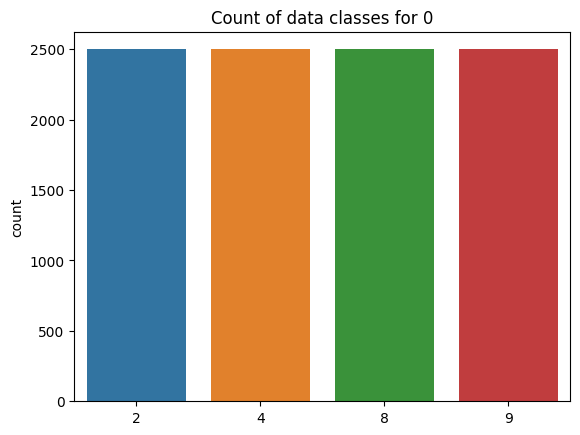

10000


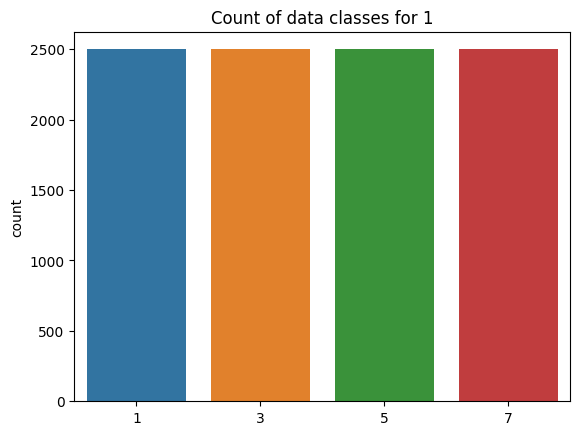

10000


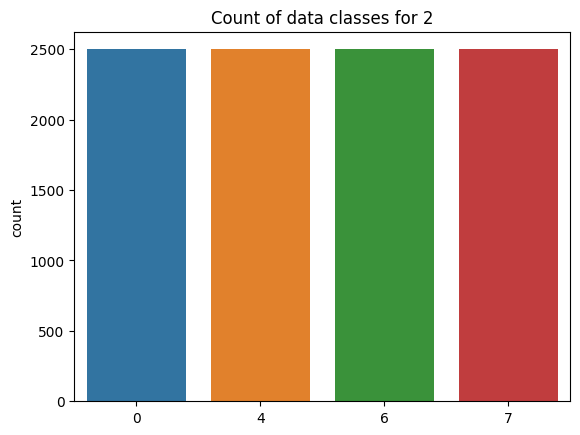

10000


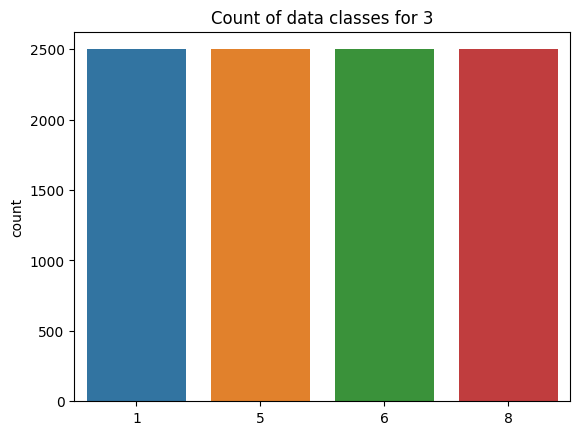

10000


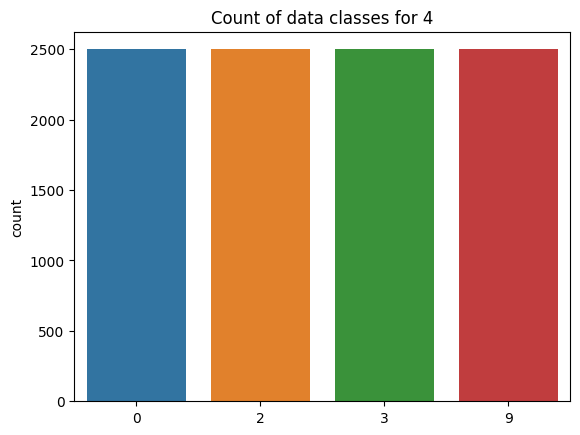

In [9]:
for i in range (len(x_clinet_list)):
    print(len(y_client_list[i]))
    getDist(y_client_list[i],num_classes,i)

In [10]:
# class Generator(nn.Module):

#     def __init__(self):
#         super(Generator, self).__init__()
#         self.main = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=128, out_channels=512, kernel_size=4, stride=1, padding=0, bias = False),
#             nn.BatchNorm2d(num_features=512,momentum=0.1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias = False),
#             nn.BatchNorm2d(num_features=256,momentum=0.1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias = False),
#             nn.BatchNorm2d(num_features=128,momentum=0.1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias = False),
#             nn.BatchNorm2d(num_features=64,momentum=0.1),
#             nn.ReLU(inplace=True),
#             nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, bias = False),
#             nn.Tanh()
#         )

#     def forward(self, input):
#         output = self.main(input)
#         return output

In [11]:
# class Discriminator(nn.Module):

#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.main = nn.Sequential(
#             spectral_norm(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias = False)),
#             nn.LeakyReLU(negative_slope= 0.1, inplace = True),

#             spectral_norm(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1, bias = False)),
#             nn.LeakyReLU(negative_slope= 0.1, inplace = True),

#             spectral_norm(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias = False)),
#             nn.LeakyReLU(negative_slope= 0.1, inplace = True),

#             spectral_norm(nn.Conv2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1, bias = False)),
#             nn.LeakyReLU(negative_slope= 0.1, inplace = True),

#             # need to calculate the number of neurons in this layer to connect each of their outputs to the next layer
#             spectral_norm(nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias = False)),
#             nn.LeakyReLU(negative_slope= 0.1, inplace = True),
#             nn.Flatten(), #flatten the output
#             spectral_norm(nn.Linear(in_features =4096,out_features =1, bias = False))
#         )

#     def neuron_calculator(in_channels,padding,kernel_size,stride,out_channels):
#         return (in_channels+2*padding-kernel_size)**2 * out_channels
#     def forward(self, input):
#         output = self.main(input)
#         return output.view(-1)


In [12]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
dev = torch.device(dev)

In [13]:
# netG = Generator().to(dev)
# netD = Discriminator().to(dev)
# summary(netG,(128,1,1))
# summary(netD,(3,32,32))

In [14]:
main_server = Server(0,learning_rate)
main_server.generator.train()
workers = []
for i in range(num_workers):
    worker = Worker(i,learning_rate)
    worker.load_worker_data(x_clinet_list[i], y_client_list[i])
    worker.discriminator.train()
    workers.append(worker)
    
# summary(main_server.generator,(128,1,1))

In [23]:
criterion = nn.BCELoss()
NOISE_DIM = 128
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(dev)
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

for epoch in range(NUM_EPOCHS):
    # Target labels not needed! <3 unsupervised
    for worker in workers:
        dataloader = DataLoader(dataset=worker.x_data,batch_size=BATCH_SIZE)
        for batch_id, real in enumerate(dataloader):
            real = real.to(dev)
            print(real.shape)
            noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1,1).to(dev)
            fake = main_server.generator(noise)

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            disc_real = worker.discriminator(real).reshape(-1)
            loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = worker.discriminator(fake.detach()).reshape(-1)
            loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            loss_disc = (loss_disc_real + loss_disc_fake) / 2
            worker.discriminator.zero_grad()
            loss_disc.backward()
            worker.d_optimizer.step()
            if batch_id % 100 == 0:
                print(
                    f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_id}/{len(dataloader)} \
                      Loss D: {loss_disc:.4f}"
                )

    ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
    # output = disc(fake).reshape(-1)
    # loss_gen = criterion(output, torch.ones_like(output))
    # gen.zero_grad()
    # loss_gen.backward()
    # opt_gen.step()

    # for batch_idx, (real, _) in enumerate(dataloader):
    #     real = real.to(device)
    #     noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
    #     fake = gen(noise)

    #     ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
    #     disc_real = disc(real).reshape(-1)
    #     loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
    #     disc_fake = disc(fake.detach()).reshape(-1)
    #     loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
    #     loss_disc = (loss_disc_real + loss_disc_fake) / 2
    #     disc.zero_grad()
    #     loss_disc.backward()
    #     opt_disc.step()

    #     ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
    #     output = disc(fake).reshape(-1)
    #     loss_gen = criterion(output, torch.ones_like(output))
    #     gen.zero_grad()
    #     loss_gen.backward()
    #     opt_gen.step()

    #     # Print losses occasionally and print to tensorboard
    #     if batch_idx % 100 == 0:
    #         print(
    #             f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
    #               Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
    #         )

    #         with torch.no_grad():
    #             fake = gen(fixed_noise)
    #             # take out (up to) 32 examples
    #             img_grid_real = torchvision.utils.make_grid(
    #                 real[:32], normalize=True
    #             )
    #             img_grid_fake = torchvision.utils.make_grid(
    #                 fake[:32], normalize=True
    #             )

    #             writer_real.add_image("Real", img_grid_real, global_step=step)
    #             writer_fake.add_image("Fake", img_grid_fake, global_step=step)

    #         step += 1

torch.Size([128, 32, 32, 3])


RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[128, 32, 32, 3] to have 3 channels, but got 32 channels instead